## Data Preparation and Exploration

60% of clients actual sales and revenues are available and make them train set and remainings are test set. Then, we would like to join all the data set to generate the whole train set and test set. We treat all NA value as 0 since we think they are without any meaning and the clients just do not have it. It's not missing from data collection. The train set has 969 observations and 39 variables while test set has 646 observations and 30 features. We investigate the dependence between multiple variables at the same time by correlation maps to understand the big picture on all the variables. The results show the correlation is consistent with common sense. 

## Classification and Regression Model

After preparing the train and test set, we would like to search for the model and algorithm to solve the task. It will break down into two steps. The first step is to search for a classification method to detect if the clients could be assigned a product. Three products will generate eight product combination. However, instead of classifying eight class here, we solve a binary problem for each product. This greedy strategy may give more possibility for clients, especially for the product combination. The most important point in terms of machining learning perspective is the data for multi-product combination is limited. When we execute cross validation, it may result in that there are not any observations for this class in the training set. In this unbalanced situation, the predictive model developed using machine learning algorithms could be biased and inaccurate. After we present the probability of the binary problem for each product, we develop a regression model to estimate the revenue.

#### Consumer Loan(CL)

We start from CL since it is most profitable among three products. The ratio of not having CL and having CL is 2.34, which clearly means it is unbalanced.  Accuracy will not be our primary metrics for evaluating models on our classification problems. Here we will use other metrics to evaluate it. In a business perspective, we will prefer to reduce false negative and give more opportunity to talk to clients even if they do not accept products in the end. Oversampling is another effective way to combat unbalanced situation. Here we try to balance the class distribution by undersampling the majority classes or oversampling the minority classes. We will use AUC as our evaluating metric because AUC only cares about ordering and it won’t be affected by this strategy. The models are performed by H2O package. We will choose the model with best performance in 5-fold cross validation from two popular algorithms GBM(Gradient Boosting Machine) and PGLM(Penalized generalized linear regression). The model from PGLM stands out in terms of the performance on AUC. The AUC value from best performance model in PGLM is 0.72. We will use this model for further classification prediction. Next, we will develop a regression model to detect how much revenue bank will get if clients have CL. We only use data from those who have this product. Similarly, we will choose the model with better performance in 5-fold cross validation from the same algorithms above GBM and penalized linear regression. Since the values of revenue are all positive, we will use gamma distribution instead of gaussian distribution. Penalized linear regression generates lower RMSE. We will choose this method for prediction on revenue. It's better to search more algorithm and more hyper parameters to determine the best one. In addition, an ensemble learning from several best models is another option to improve prediction ability. Due to limited resource, we just assume PGLM model is the best one and we will perform it on the other two products as well. 

#### Credit Card(CC)

Data for CC is more unbalanced. We will use the same strategy as consumer loan to handle it. We skip the model-search step and assume PGLM is the best single model for CC because we conclude it from CL. What we need to do is to investigate the best model from this method and check if the value of evaluation metrics is reasonable and acceptable. The top three important features are number of credit transactions on current accounts, number of credit transactions on current accounts and monthly debit turnover.

#### Mutual Fund(MF)

Data for MF is even more unbalanced. We will follow the same strategy with the previous two to investigate the best model from PGLM and check if the value of evaluation metrics is reasonable and acceptable.The top three important features for mutual fund are monthly number of debit cashless transactions via card, monthly debit turnover and monthly credit turnover on current accounts. Those features are from different assessment perspective on clients which makes MF the comprehensive assessment product on clients. This is the reason why only a few clients have this product.

## Prediction

After constructing models for each product on clients, we start to predict on the test set and get product classification and revenue prediction on each client. Then we make use of the probability of classification prediction and value of revenue to calculate the expectated value on each client. There are two options for selecting 100 clients to offer the product. The first approach is to find the largest 100 expectated value and those clients are the targets no matter how many products one client could have. The other one is to select them sequentially by numbers of products which means we start from those clients who have high propensity to buy three products and then two products, one product in the end. For the clients who may buy the same number of products, we still sort them by the expected value. The second one can help to seize the market opportunities first if we suppose clients may own limited similar products in the market. The first approach gives better revenue estimation which means some clients with several products do not generate as much revenue as some clients only with one product. However, the total difference is not very large and I would prefer the second approach since seizing the market on diversified customers is crucial and vital in terms of business perspective. In the end, we will give the list on the potential clients with their products and revenue. For instance, client 1183, 1225, etc will be targeted with all three products while client 9, 1123, etc will be targeted with CL and CC. For some clients, like 243 and 748, they will be offered only one product respectively.

## Conclusion and Future Work

We develop a greedy method to explore each product on each client. The PGLM is to be found as the best single model for both classification and regression on prediction ability. In order to maximize the revenue in terms of business perspective, we select clients by numbers of products which is sorted by the expected revenue value. We could also explore descriptive statistics more by percentage for product combination to see if the result is consistent. It is better to try more models and more hyper parameters on the training data to improve the prediction performance if the cluster computing is powerful. In addition, we could also use ensemble methods to combine those top best models together and give a more reliable prediction.

## Code and Figures

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
%matplotlib inline
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

#### Data Preparation and Exploration

In [4]:
## Read DATA into each files
xl = pd.ExcelFile("Task_Data_Scientist_Dataset.xlsx")
products = xl.parse("Products_ActBalance")
flow = xl.parse("Inflow_Outflow")
sales = xl.parse("Sales_Revenues") 
social = xl.parse("Soc_Dem")

print("Total customers for each file are", social.shape[0], products.shape[0],flow.shape[0],sales.shape[0])
print("Total number for no gender clients is", social['Sex'].isnull().sum())

## replace male and female to 1 and 0 respectively, NA for 2 
social['Sex'] = social['Sex'].fillna(2).replace({'F':0,'M':1}).astype('category')

Total customers for each file are 1615 1615 1587 969
Total number for no gender clients is 3


In [5]:
## add revenue and labels for each products to see if customers are assigned into products 
# and how many products they have
sales['Sum'] = sales[['Revenue_MF','Revenue_CC','Revenue_CL']].sum(axis=1)
sales['NumPro'] = sales[['Sale_MF','Sale_CC','Sale_CL']].sum(axis=1)

## give unique labels for product combination
sales['Label'] = sales["Sale_MF"].map(str) + sales["Sale_CC"].map(str) + sales["Sale_CL"].map(str)

## assign dataset by sum value
assign = sales.loc[sales['Sum'] > 0]
unassign = sales.loc[sales['Sum'] == 0] 

## calculate each mean without 0 for plot
MF_AVG = assign["Revenue_MF"].replace(0, np.NaN).mean()
CC_AVG = assign["Revenue_CC"].replace(0, np.NaN).mean()
CL_AVG = assign["Revenue_CL"].replace(0, np.NaN).mean() 

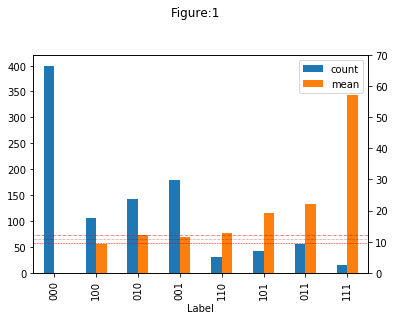

In [6]:
## aggregation by group on mean revenue and count
agg = (sales.groupby(['Label'])
            .agg({'Sum':['mean'],'Label':['count']})
            .reindex(['000', '100', '010', '001','110','101','011','111']))
agg.columns = agg.columns.droplevel(0)
agg = agg[['count', 'mean']] 

## plot in one figure with 2 y-axis
ax = agg.plot(kind="bar")
ax2 = ax.twinx()
for r in ax.patches[len(agg):]:
    r.set_transform(ax2.transData)
ax2.set_ylim(0, 70); 
ax2.axhline(y=MF_AVG, xmin=-1, xmax=1, color='r', linestyle='--', lw=0.5)# average mutual fund 
ax2.axhline(y=CC_AVG, xmin=-1, xmax=1, color='darkred', linestyle=':', lw=0.5)# average credit 
ax2.axhline(y=CL_AVG, xmin=-1, xmax=1, color='firebrick', linestyle='-.', lw=0.5)# average consumer
plt.suptitle('Figure:1', x=0.5, y=1.05, ha='center') 

In [7]:
## creat the train set and test set, replace NA with 0 
Train = (pd.merge(sales, social, how='left', on=['Client'])
           .merge(products, how='left', on=['Client'])
           .merge(flow, how='left', on=['Client'])
           .fillna(0))

Train_not = social[~social.Client.isin(Train.Client)]
Test =  (pd.merge(Train_not,products, how='left', on=['Client'])
           .merge(flow, how='left', on=['Client'])
           .fillna(0))

In [6]:
## Generate correlation map
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]
corr = Train.corr()
corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Correlation Map")\
    .set_precision(2)\
    .set_table_styles(magnify())

#### Classification and Regression Model

##### Consumer Loan

In [10]:
h2o.init(nthreads = -1,max_mem_size = "8g")

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,49 secs
H2O cluster version:,3.10.4.8
H2O cluster version age:,3 months and 21 days !!!
H2O cluster name:,H2O_from_python_gubingjing_m1k9po
H2O cluster total nodes:,1
H2O cluster free memory:,6.949 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [11]:
response = "Sale_CL"
Train_CL = Train.drop(['Client','Sale_MF','Sale_CC','Revenue_MF',
                       'Revenue_CC','Sum','NumPro','Label'], axis = 1)

## calculate imbalanced ratio
ratio = Train_CL[response].value_counts()[0]/Train_CL[response].value_counts()[1]


## pandas to h2o dataframe
Train_CL = h2o.H2OFrame(Train_CL)

predictors = Train_CL.columns
del predictors[0:2]

## the response variable is an integer, we will turn it into a categorical/factor for binary classification
Train_CL[response] = Train_CL[response].asfactor()  

print("The unbalanced data ratio is", ratio)

Parse progress: |█████████████████████████████████████████████████████████| 100%
The unbalanced data ratio is 2.34137931034


In [10]:
### GBM
## create hyperameter 
hyper_params_gbm = {'max_depth' : [5,10,15,20],
                    'sample_rate': [0.01, 0.02, 0.05, 0.1],
                    'learn_rate' : [0.01, 0.02, 0.05, 0.1],
                    'col_sample_rate': [0.01, 0.02, 0.05, 0.1]
                    }

gbm_final_grid = H2OGradientBoostingEstimator(
                    ntrees=1000,
                    ## learning rate annealing: learning_rate shrinks by 1% after every tree 
                    ## (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    ## fix a random number generator seed for reproducibility
                    seed = 2017,
                    # usually use 5 or 10                     
                    nfolds = 5, 
                    fold_assignment = "Stratified",
                    balance_classes = True,
                    ## early stopping once the validation AUC doesn't improve  
                    stopping_rounds = 5,   
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-3)

## create search criteria
search_criteria_gbm = {'strategy': "RandomDiscrete",
                        'max_runtime_secs': 3600,  ## limit the runtime to 60 minutes
                        'seed' : 2017,
                        'stopping_rounds' : 5,
                        'stopping_metric' : "AUC",
                        'stopping_tolerance': 1e-3
                        }
            
#Build grid search with previously made GBM and hyper parameters
gbm_grid = H2OGridSearch(gbm_final_grid, 
                         hyper_params = hyper_params_gbm, 
                         search_criteria = search_criteria_gbm,
                         grid_id = 'gbm_grid_CL')

#Train grid search
gbm_grid.train(x = predictors, 
               y = response,
               training_frame = Train_CL)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [11]:
sorted_gbm_grid = gbm_grid.get_grid(sort_by='auc',decreasing=True)
best_model_gbm = h2o.get_model(sorted_gbm_grid.sorted_metric_table()['model_ids'][0])
print("The auc from best performance model in GBM is",  best_model_gbm.auc())

The auc from best performance model in GBM is 0.6427989521439575


In [12]:
### penalized  regression
## create hyperameter 
hyper_params_glm = {'lambda': [0.5, 0.1, 0.01, 0.001, 0.0001],
                    'alpha' : [0, 0.5, 1]
                    }

glm_final_grid  = H2OGeneralizedLinearEstimator(family = 'binomial',
                                                ## set same seed and folds,make sure it has same folds with the other method
                                                seed = 2017, 
                                                nfolds = 5,
                                                fold_assignment = "Stratified",
                                                balance_classes = True)
 
#Build grid search with previously hyper parameters    
glm_grid = H2OGridSearch(model = glm_final_grid ,
                         hyper_params = hyper_params_glm,
                         search_criteria = {'strategy': "Cartesian"},
                         grid_id = 'glm_grid_CL')

## Train grid search
glm_grid.train(x = predictors, y = response, training_frame = Train_CL)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [13]:
sorted_glm_grid = glm_grid.get_grid(sort_by = 'auc', decreasing = True)
best_model_glm = h2o.get_model(sorted_glm_grid.sorted_metric_table()['model_ids'][0])
print("The auc from best performance model in GLM is",  best_model_glm.auc())

The auc from best performance model in GLM is 0.7163196384134883


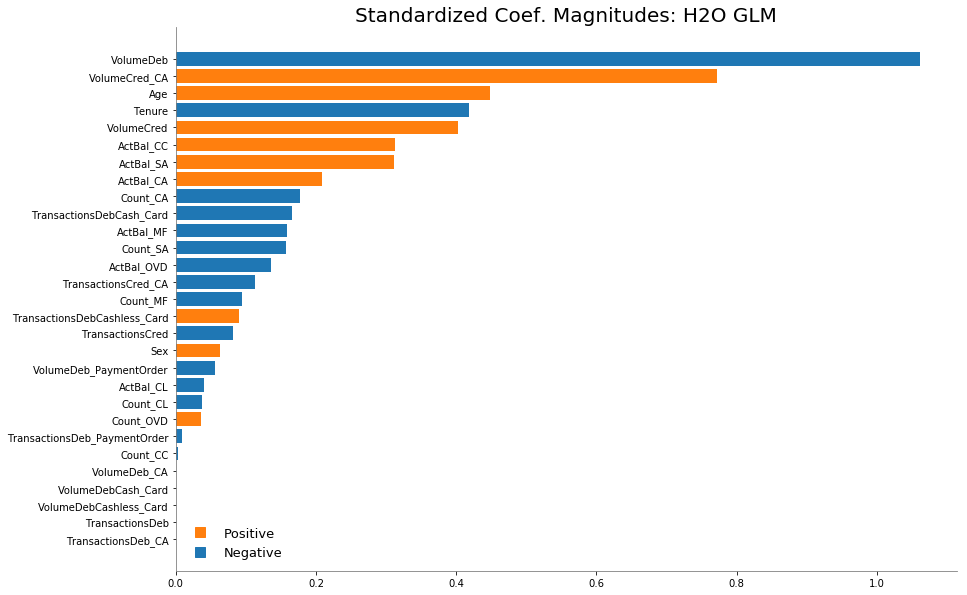

In [14]:
best_model_glm.std_coef_plot()
best_model_CL = best_model_glm

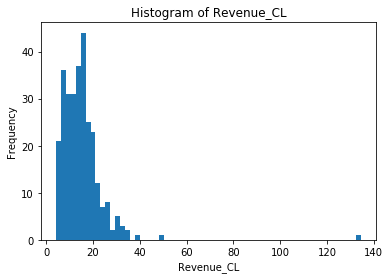

In [15]:
## Select data from those clients have consumer loan
Train_CL_pos = Train_CL[Train_CL['Sale_CL'] == '1']

## give the response and predictors 
response_reg = "Revenue_CL"
predictors_reg = Train_CL_pos.columns
del predictors_reg[0:1]
Train_CL_pos['Revenue_CL'].hist(breaks='FD')

In [16]:
### GBM
## create hyperameter 
hyper_params_gbm = {'max_depth' : [5,10,15,20],
                    'sample_rate': [0.01, 0.02, 0.05, 0.1],
                    'learn_rate' : [0.01, 0.02, 0.05, 0.1],
                    'col_sample_rate': [0.01, 0.02, 0.05, 0.1]
                    }

gbm_final_grid_reg = H2OGradientBoostingEstimator(
                       distribution = 'gamma',   
                       ntrees = 1000,
                       ## learning rate annealing: learning_rate shrinks by 1% after every tree 
                       ## (use 1.00 to disable, but then lower the learning_rate)
                       learn_rate_annealing = 0.99,
                       ## fix a random number generator seed for reproducibility
                       seed = 2017,
                       # usually use 5 or 10                     
                       nfolds = 5, 
                       ## early stopping once the validation rmse doesn't improve  
                       stopping_rounds = 5,   
                       stopping_metric = "rmse",
                       stopping_tolerance = 1e-4)

## create search criteria
search_criteria_gbm_reg = {'strategy': "RandomDiscrete",
                           'max_runtime_secs': 3600,  ## limit the runtime to 60 minutes
                           'seed' : 2017,
                           'stopping_rounds' : 5,
                           'stopping_metric' : "rmse",
                           'stopping_tolerance': 1e-4
                           }
            
#Build grid search with previously made GBM and hyper parameters
gbm_grid_reg = H2OGridSearch(gbm_final_grid_reg, 
                             hyper_params = hyper_params_gbm, 
                             search_criteria = search_criteria_gbm_reg,
                             grid_id = 'gbm_grid_CL_reg')

#Train grid search
gbm_grid_reg.train(x = predictors_reg, 
                   y = response_reg,
                   training_frame = Train_CL_pos)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [16]:
### penalized  regression
## create hyperameter 
hyper_params_glm = {'lambda': [0.5, 0.1, 0.01, 0.001, 0.0001],
                    'alpha' : [0, 0.5, 1]
                    }

glm_final_grid_reg  = H2OGeneralizedLinearEstimator(family = 'gamma', 
                                                    link = 'inverse',
                                                ## set same seed and folds,make sure it has same folds with the other method
                                                    seed = 2017, 
                                                    nfolds = 5)

#Build grid search with previously hyper parameters           
glm_grid_reg = H2OGridSearch(model = glm_final_grid_reg ,
                             hyper_params = hyper_params_glm,
                             search_criteria = {'strategy': "Cartesian"},
                             grid_id = 'glm_grid_CL_reg')

#Train grid search
glm_grid_reg.train(x = predictors_reg, y = response_reg, training_frame = Train_CL_pos)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [18]:
sorted_gbm_grid_reg = gbm_grid_reg.get_grid(sort_by = 'rmse', decreasing = True)
best_model_gbm_reg = h2o.get_model(sorted_gbm_grid_reg.sorted_metric_table()['model_ids'][0])
print("The rmse from best performance model in GBM is",  best_model_gbm_reg.rmse())

The rmse from best performance model in GBM is 10.088901717354496


In [17]:
sorted_glm_grid_reg = glm_grid_reg.get_grid(sort_by = 'rmse', decreasing = True)
best_model_glm_reg = h2o.get_model(sorted_glm_grid_reg.sorted_metric_table()['model_ids'][0])
print("The rmse from best performance model in GLM is",  best_model_glm_reg.rmse())

The rmse from best performance model in GLM is 7.048253291818938


In [18]:
best_model_CL_reg = best_model_glm_reg

##### Credit Card

In [19]:
response = "Sale_CC"
Train_CC = Train.drop(['Client','Sale_MF','Sale_CL','Revenue_MF',
                       'Revenue_CL','Sum','NumPro','Label'], axis = 1)

## calculate imbalanced ratio
ratio = Train_CC[response].value_counts()[0]/Train_CC[response].value_counts()[1]


## pandas to h2o dataframe
Train_CC = h2o.H2OFrame(Train_CC)

predictors = Train_CC.columns
del predictors[0:2]

## the response variable is an integer, we will turn it into a categorical/factor for binary classification
Train_CC[response] = Train_CC[response].asfactor()  

print("The unbalanced data ratio is", ratio)

Parse progress: |█████████████████████████████████████████████████████████| 100%
The unbalanced data ratio is 3.0041322314


In [20]:
### penalized  regression
## create hyperameter 
hyper_params_glm = {'lambda': [0.5, 0.1, 0.01, 0.001, 0.0001],
                    'alpha' : [0, 0.5, 1]
                    }

glm_final_grid  = H2OGeneralizedLinearEstimator(family = 'binomial',
                                                ## set same seed and folds,make sure it has same folds with the other method
                                                seed = 2017, 
                                                nfolds = 5,
                                                fold_assignment = "Stratified",
                                                balance_classes = True)

#Build grid search with previously hyper parameters            
glm_grid = H2OGridSearch(model = glm_final_grid ,
                         hyper_params = hyper_params_glm,
                         search_criteria = {'strategy': "Cartesian"},
                         grid_id = 'glm_grid_CC')

#Train grid search
glm_grid.train(x = predictors, y = response, training_frame = Train_CC)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [21]:
sorted_glm_grid = glm_grid.get_grid(sort_by = 'auc', decreasing = True)
best_model_glm = h2o.get_model(sorted_glm_grid.sorted_metric_table()['model_ids'][0])
print("The auc from best performance model in GLM is",  best_model_glm.auc())

The auc from best performance model in GLM is 0.708356542794457


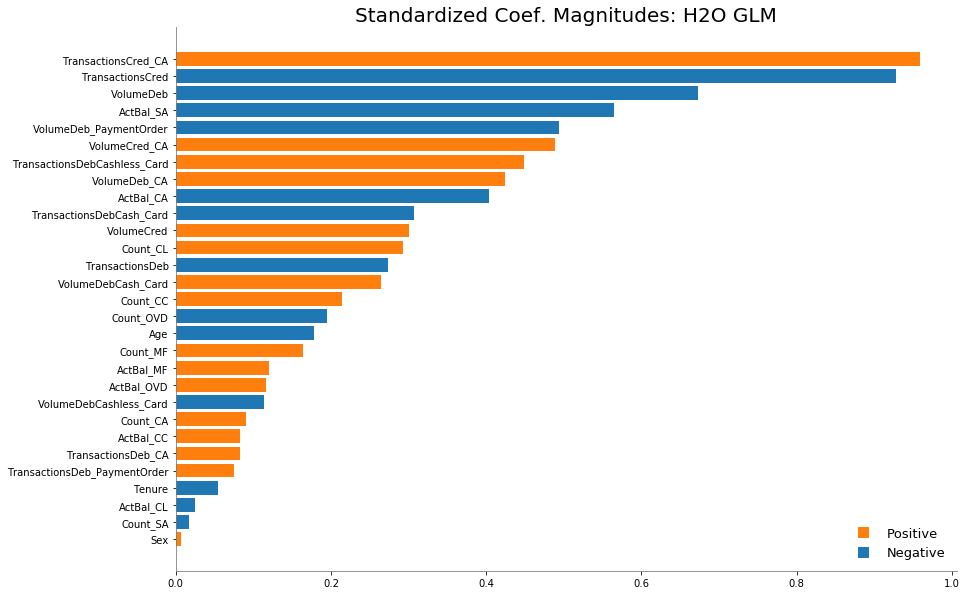

In [22]:
best_model_glm.std_coef_plot()
best_model_CC = best_model_glm

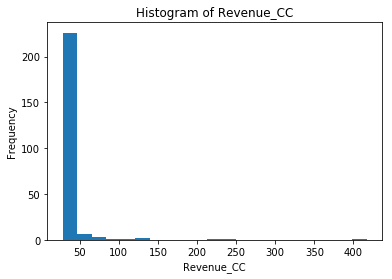

In [23]:
## Select data from those clients have credit cards
Train_CC_pos = Train_CC[Train_CC['Sale_CC'] == '1']

## give the response and predictors 
response_reg = "Revenue_CC"
predictors_reg = Train_CC_pos.columns
del predictors_reg[0:1]
Train_CC_pos['Revenue_CC'].hist('Scott')

In [24]:
### penalized  regression
hyper_params_glm = {'lambda': [0.5, 0.1, 0.01, 0.001, 0.0001],
                    'alpha' : [0, 0.5, 1]
                    }

glm_final_grid_reg  = H2OGeneralizedLinearEstimator(family = 'gamma', 
                                                    link = 'inverse',
                                                ## set same seed and folds,make sure it has same folds with the other method
                                                    seed = 2017, 
                                                    nfolds = 5)

#Build grid search with previously hyper parameters 
glm_grid_reg = H2OGridSearch(model = glm_final_grid_reg ,
                             hyper_params = hyper_params_glm,
                             search_criteria = {'strategy': "Cartesian"},
                             grid_id = 'glm_grid_CC_reg')

#Train grid search
glm_grid_reg.train(x = predictors_reg, y = response_reg, training_frame = Train_CC_pos)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [25]:
sorted_glm_grid_reg = glm_grid_reg.get_grid(sort_by = 'rmse', decreasing = True)
best_model_glm_reg = h2o.get_model(sorted_glm_grid_reg.sorted_metric_table()['model_ids'][0])
print("The rmse from best performance model in GLM is",  best_model_glm_reg.rmse())
best_model_CC_reg = best_model_glm_reg

The rmse from best performance model in GLM is 20.41206765131247


##### Mutual Fund

In [26]:
response = "Sale_MF"
Train_MF = Train.drop(['Client','Sale_CC','Sale_CL','Revenue_CC',
                       'Revenue_CL','Sum','NumPro','Label'], axis = 1)

## calculate imbalanced ratio
ratio = Train_MF[response].value_counts()[0]/Train_MF[response].value_counts()[1]


## pandas to h2o dataframe
Train_MF = h2o.H2OFrame(Train_MF)

predictors = Train_MF.columns
del predictors[0:2]

## the response variable is an integer, we will turn it into a categorical/factor for binary classification
Train_MF[response] = Train_MF[response].asfactor()  

print("The unbalanced data ratio is", ratio)

Parse progress: |█████████████████████████████████████████████████████████| 100%
The unbalanced data ratio is 4.0207253886


In [27]:
### penalized  regression
hyper_params_glm = {'lambda': [0.5, 0.1, 0.01, 0.001, 0.0001],
                    'alpha' : [0, 0.5, 1]
                    }

glm_final_grid  = H2OGeneralizedLinearEstimator(family = 'binomial',
                                                ## set same seed and folds,make sure it has same folds with the other method
                                                seed = 2017, 
                                                nfolds = 5,
                                                fold_assignment = "Stratified",
                                                balance_classes = True)

#Build grid search with previously hyper parameters 
glm_grid = H2OGridSearch(model = glm_final_grid ,
                         hyper_params = hyper_params_glm,
                         search_criteria = {'strategy': "Cartesian"},
                         grid_id = 'glm_grid_MF')

#Train grid search
glm_grid.train(x = predictors, y = response, training_frame = Train_MF)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [28]:
sorted_glm_grid = glm_grid.get_grid(sort_by = 'auc', decreasing = True)
best_model_glm = h2o.get_model(sorted_glm_grid.sorted_metric_table()['model_ids'][0])
print("The auc from best performance model in GLM is",  best_model_glm.auc())

The auc from best performance model in GLM is 0.693619464772181


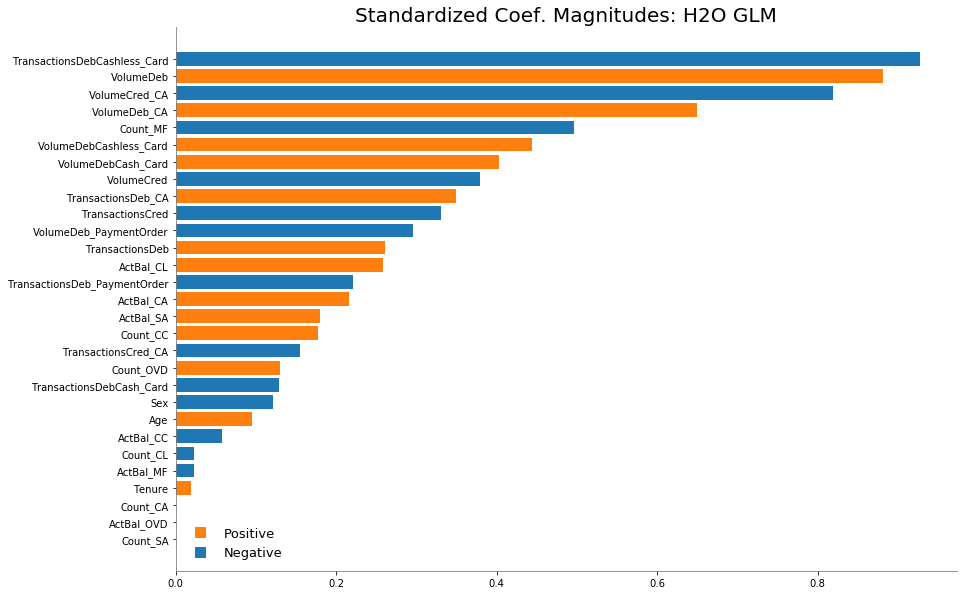

In [29]:
best_model_glm.std_coef_plot()
best_model_MF = best_model_glm

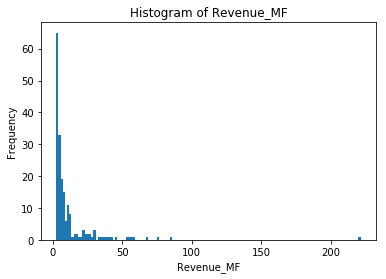

In [30]:
## Select data from those clients have credit cards
Train_MF_pos = Train_MF[Train_MF['Sale_MF'] == '1']

## give the response and predictors 
response_reg = "Revenue_MF"
predictors_reg = Train_MF_pos.columns
del predictors_reg[0:1]
Train_MF_pos['Revenue_MF'].hist('FD')

In [31]:
### penalized  regression
hyper_params_glm = {'lambda': [0.5, 0.1, 0.01, 0.001, 0.0001],
                    'alpha' : [0, 0.5, 1]
                    }

glm_final_grid_reg  = H2OGeneralizedLinearEstimator(family = 'gamma', 
                                                    link = 'inverse',
                                                ## set same seed and folds,make sure it has same folds with the other method
                                                    seed = 2017, 
                                                    nfolds = 5)

#Build grid search with previously hyper parameters 
glm_grid_reg = H2OGridSearch(model = glm_final_grid_reg ,
                             hyper_params = hyper_params_glm,
                             search_criteria = {'strategy': "Cartesian"},
                             grid_id = 'glm_grid_MF_reg')

#Train grid search
glm_grid_reg.train(x = predictors_reg, y = response_reg, training_frame = Train_MF_pos)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [32]:
sorted_glm_grid_reg = glm_grid_reg.get_grid(sort_by = 'rmse', decreasing = True)
best_model_glm_reg = h2o.get_model(sorted_glm_grid_reg.sorted_metric_table()['model_ids'][0])
print("The rmse from best performance model in GLM is",  best_model_glm_reg.rmse())
best_model_MF_reg = best_model_glm_reg

The rmse from best performance model in GLM is 13.07515885459087


### Prediction

In [33]:
Test =  h2o.H2OFrame(Test)
## predict on each client and product.
preds_CL = best_model_CL.predict(Test)
preds_CC = best_model_CC.predict(Test)
preds_MF = best_model_MF.predict(Test)
preds_CL_revenue = best_model_CL_reg.predict(Test)
preds_CC_revenue = best_model_CC_reg.predict(Test)
preds_MF_revenue = best_model_MF_reg.predict(Test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [34]:
## put all results together
Prediction = (Test["Client"].cbind(preds_CL).cbind(preds_CL_revenue) 
                            .cbind(preds_CC).cbind(preds_CC_revenue) 
                            .cbind(preds_MF).cbind(preds_MF_revenue))

## drop one of the probability column in each prediction and change the column name 
cols = [c for c in Prediction.columns if c.lower()[:2] != 'p1']

## Categorical variable to numerical
Preds = Prediction[cols].asnumeric().as_data_frame(use_pandas=True)
Preds.columns = ['Client', 'Preds_CL', 'CL_Prob', 'CL_Re', 'Preds_CC',
                 'CC_Prob', 'CC_Re', 'Preds_MF', 'MF_Prob', 'MF_Re']

## Replace negative values to 0
Preds[Preds < 0] = 0

In [35]:
## get the number of products for each client and get the reveneue expectation for each client
Preds['SUM'] = Preds[['Preds_CL','Preds_CC','Preds_MF']].sum(axis = 1)
Preds['EXP'] = (Preds['Preds_CL'] * Preds['CL_Prob'] * Preds['CL_Re']  + 
                Preds['Preds_CC'] * Preds['CC_Prob'] * Preds['CC_Re']  +
                Preds['Preds_MF'] * Preds['MF_Prob'] * Preds['MF_Re']) 



In [36]:
## First approach sort expected value only
Predict_AP1 = (Preds.sort_values('EXP',ascending = False)
                    .head(100))

## Select top 100 and calculate total revenue
Client_AP1 = Predict_AP1['Client']
Client_AP1_RE = (Predict_AP1['CL_Re'] * Predict_AP1['Preds_CL'] + 
                 Predict_AP1['CC_Re'] * Predict_AP1['Preds_CC'] +
                 Predict_AP1['MF_Re'] * Predict_AP1['Preds_MF']).sum()


print("The selected clients are", Client_AP1.tolist())
print("The estimated revenue",np.floor(Client_AP1_RE))

The selected clients are [243, 748, 128, 336, 1611, 1211, 1497, 9, 1123, 124, 1374, 1110, 1183, 476, 1039, 803, 1314, 528, 1138, 504, 1225, 1127, 1304, 699, 289, 161, 474, 1540, 1051, 1241, 168, 463, 1349, 25, 1186, 1380, 1297, 710, 419, 978, 227, 1466, 1250, 870, 57, 331, 5, 797, 1597, 97, 350, 1150, 1443, 516, 3, 1037, 1341, 541, 1227, 375, 919, 1498, 595, 1530, 772, 779, 521, 1599, 781, 1422, 1474, 299, 265, 199, 1097, 668, 51, 565, 545, 400, 531, 94, 188, 239, 524, 1440, 1218, 164, 329, 1331, 677, 505, 1504, 140, 685, 1252, 1468, 1146, 1300, 345]
The estimated revenue 2612.0


In [37]:
## Second approach sort by numbers of product and then expected value
Predict_AP2 = (Preds.sort_values(['SUM','EXP'],ascending = [False,False])
                    .head(100))

## Select top 100 and calculate total revenue
Client_AP2 = Predict_AP2['Client']
Client_AP2_RE = (Predict_AP2['CL_Re'] * Predict_AP2['Preds_CL'] + 
                 Predict_AP2['CC_Re'] * Predict_AP2['Preds_CC'] +
                 Predict_AP2['MF_Re'] * Predict_AP2['Preds_MF']).sum()

print("The selected clients are", Client_AP2.tolist())
print("The estimated revenue",np.floor(Client_AP2_RE))

The selected clients are [1183, 1225, 161, 710, 350, 668, 153, 1611, 1211, 1497, 9, 1123, 1110, 803, 1314, 528, 699, 289, 474, 1051, 1241, 168, 1349, 1186, 1380, 978, 227, 870, 57, 331, 5, 797, 1597, 97, 1443, 516, 3, 1341, 1227, 1498, 595, 1530, 779, 521, 1599, 781, 1422, 1474, 299, 265, 1097, 545, 531, 94, 188, 239, 524, 1440, 1218, 164, 329, 677, 505, 1252, 1122, 1260, 559, 32, 403, 1543, 89, 383, 530, 866, 701, 362, 1516, 394, 1365, 1240, 353, 1082, 760, 1200, 1603, 878, 1480, 1119, 697, 1458, 1569, 217, 583, 532, 389, 1289, 1455, 1077, 243, 748]
The estimated revenue 2415.0


In [41]:
with pd.option_context('display.max_rows', 100):
     print(Predict_AP2[['Client','Preds_CL','CL_Re','Preds_CC','CC_Re','Preds_MF','MF_Re']])

     Client  Preds_CL       CL_Re  Preds_CC      CC_Re  Preds_MF      MF_Re
165    1183         1   11.436163         1  12.455024         1   6.707102
527    1225         1   11.409076         1  11.495388         1   4.995206
163     161         1   23.277084         1   7.234524         1   2.109868
191     710         1    9.940661         1   8.228515         1   5.573212
404     350         1   11.820709         1  11.138535         1   4.780760
27      668         1   11.775521         1   8.837270         1   2.188997
343     153         1   11.148826         1  28.972465         1   2.779073
56     1611         1   11.734387         1  28.223829         0  10.337892
488    1211         1    8.765144         0   4.197448         1  32.909111
464    1497         1   13.505602         1  23.299032         0   9.994098
64        9         1   13.376229         1  25.293340         0   7.925624
309    1123         1   13.479886         1  23.426505         0   8.470601
614    1110 

In [ ]:
h2o.cluster.shutdown()